<a href="https://colab.research.google.com/github/RebeccaKessler/Otter_Group_Project/blob/main/BivariateAnalysis_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libaries

import numpy as np
import pandas as pd
import os
import re
import plotly.express as px
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")
!pip install stargazer
from stargazer.stargazer import Stargazer
!pip install linearmodels
from linearmodels.panel import PanelOLS

In [ ]:
#importing datasets
df_temp = pd.read_csv('Temp_1961-2021.csv')
df_potato = pd.read_csv('Yield_t.csv')
df_yield = pd.read_csv('Potatoes_tha.csv')

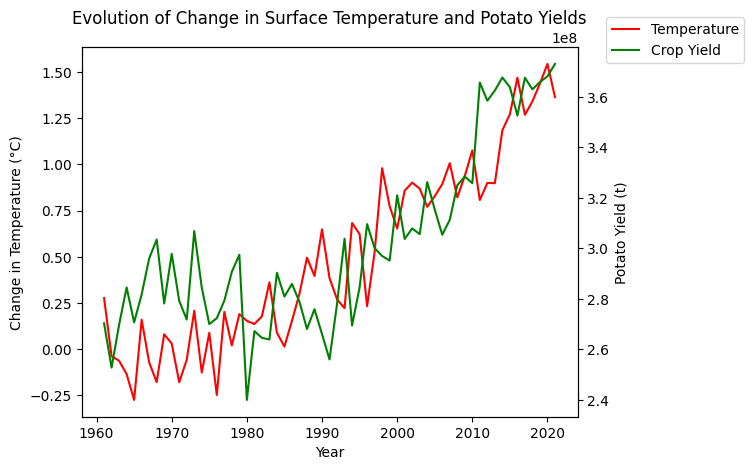

In [ ]:
# Create a figure and axis for the first y-axis
fig, ax1 = plt.subplots()

# Plot the first line on the first y-axis
df_sum1 = df_temp.groupby('Year')['Value'].mean().reset_index()
ax1.plot(df_sum1["Year"], df_sum1["Value"], label='Temperature', color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('Change in Temperature (°C)', color='black')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the second line on the second y-axis
df_sum2 = df_potato.groupby('Year')['Value'].sum().reset_index()
ax2.plot(df_sum2['Year'], df_sum2['Value'], label='Crop Yield', color='green')
ax2.set_ylabel('Potato Yield (t)', color='black')

# Add a legend for both lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax2.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(1.35, 1.1))

plt.title('Evolution of Change in Surface Temperature and Potato Yields')
# Show the plot
plt.show()

In [ ]:
#calculating the evolution of temperature by taking the mean between 2020 - 2021
df_temp_evol = df_temp[df_temp['Year'] > 2016]
df_temp_evol = df_temp_evol[df_temp_evol['Year'] < 2022]
df_temp_evol.isna().sum()
df_temp_evol = df_temp_evol.groupby('Area')['Value'].mean().reset_index()
df_temp_evol.describe()

,Value
count,107.000000
mean,1.390368
std,0.386764
min,0.346000
25%,1.126700
50%,1.332200
75%,1.636500
max,2.196200


In [ ]:
#calculating evolution of potato yield by comparing the mean
value_new = 0
value_old = 0
growth = 0
df_yield_evol = df_yield.loc[df_yield.Area == "Nothing",["Area","Value"]]
for c in list(df_yield.Area.unique()):
    value_new = df_yield.loc[(df_yield.Area == c) & (df_yield.Year.isin(list(range(2020,2022)))),"Value"].mean()
    value_old = df_yield.loc[(df_yield.Area == c) & (df_yield.Year.isin(list(range(1970,1972)))),"Value"].mean()
    growth = ((value_new-value_old)/value_old)*100
    new_row = {"Area": c, "Value": growth}
    df_yield_evol  = df_yield_evol.append(new_row,ignore_index=True)

In [ ]:
#merge temperature and potato efficiency
df_merged = pd.merge(df_temp_evol, df_yield_evol, on='Area', how='inner')

In [ ]:
#create continent clusters
Africa = ["Algeria",'Angola','Cameroon','Central African Republic','Chad','Democratic Republic of the Congo','Egypt','Eswatini','Ethiopia PDR', 'Kenya','Lesotho','Libya','Madagascar',"Malawi","Mauritania",  'Mauritius',  'Morocco',  'Mozambique',  'Nigeria',  'Senegal', 'South Africa',  'Tunisia', 'Uganda',  'United Republic of Tanzania',  'Zambia','Zimbabwe']
NA = ['Canada','Cuba','Dominica','Dominican Republic','El Salvador','Guatemala','Haiti','Honduras', "Mexico",  'Nicaragua',  'United States of America']
SA = ['Argentina','Bolivia (Plurinational State of)','Brazil','Chile','Colombia','Ecuador', "Paraguay",  'Peru', 'Uruguay', 'Venezuela (Bolivarian Republic of)']
Asia = ["Afghanistan",'Bangladesh','Bhutan','Cyprus',"China","Democratic People's Republic of Korea",'India','Indonesia','Iran (Islamic Republic of)','Iraq','Israel', 'Japan','Jordan',"Lao People's Democratic Republic", 'Lebanon',  'Mongolia',  'Myanmar',  'Nepal',  'Pakistan',  'Philippines',  'Republic of Korea', 'Saudi Arabia',  'Sri Lanka',  'Syrian Arab Republic',  'Thailand',  'Turkey',  'Viet Nam']
Europe = ["USSR",'Albania','Austria','Belgium-Luxembourg','Bulgaria','Czechoslovakia','Denmark','Faroe Islands','Finland','France','Germany','Greece','Hungary','Iceland','Ireland','Italy', "Malta",  'Netherlands (Kingdom of the)',  'Norway',  'Poland', 'Portugal',  'Romania',  'Spain', 'Sweden',  'Switzerland',  'United Kingdom of Great Britain and Northern Ireland',  'Yugoslav SFR']
Oceania = ['Australia','Fiji','French Polynesia', "New Caledonia", 'New Zealand', 'Papua New Guinea']

In [ ]:
def regroup (c_list,y_list,df_,name_of_region):
  value = 0
  for y in y_list:
    value = df_.loc[(df_.Area.isin(c_list)) & (df_.Year == y),"Value"].sum()
    new_row = {"Area": name_of_region, "Value": value, "Year": y}
    df_ = df_.append(new_row,ignore_index=True)
  df_ = df_.loc[~(df_.Area.isin(c_list))]
  df_ = df_.sort_values(by = ["Area","Year"])
  return df_

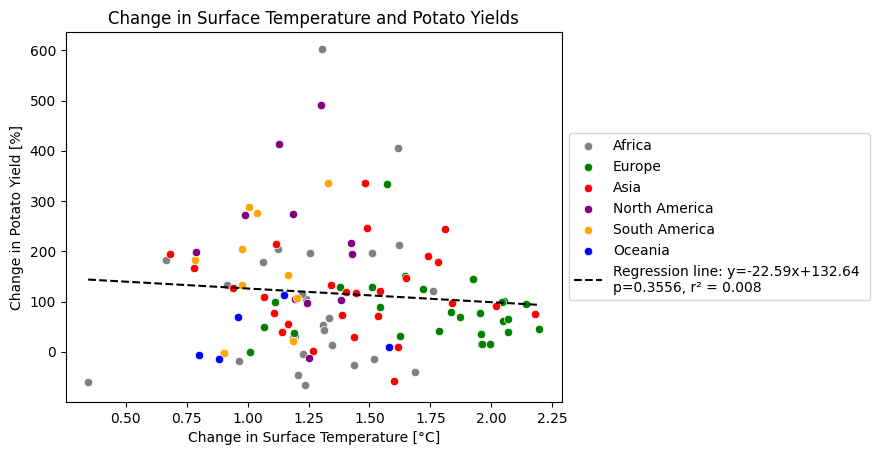

In [ ]:
#regression
for continent_list, continent_name in [(Africa, 'Africa'), (Europe, 'Europe'), (NA, 'North America'), (SA, 'South America'), (Asia, 'Asia'), (Oceania, 'Oceania')]:
    df_merged.loc[df_merged['Area'].isin(continent_list), 'continent'] = continent_name

continent_colors = {
    "Africa": "grey",
    "Europe": "green",
    "Asia": "red",
    "North America": "purple",
    "South America": "orange",
    "Oceania": "blue",
}

for continent, color in continent_colors.items():
    subset = df_merged[df_merged["continent"] == continent]
    sns.scatterplot(x=subset["Value_x"], y=subset["Value_y"], label=continent, color=color)

df_tha_sorted_values = df_merged.copy().sort_values("Value_x")
x = df_tha_sorted_values.copy().Value_x
y = df_tha_sorted_values.copy().Value_y

res = stats.linregress(x, y)
trendline = res.slope * x + res.intercept

line = f'Regression line: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.4f}, r² = {ols_canned_results.rsquared:.3f}'

plt.plot(x, trendline, '--', color='k', label=line)

plt.xlabel('Change in Surface Temperature [°C]')
plt.ylabel('Change in Potato Yield [%]')
plt.title('Change in Surface Temperature and Potato Yields')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
ols_canned_results = sm.OLS.from_formula('Value_y ~ Value_x', df_merged).fit()
ols_canned_results.params

Intercept    153.120371
Value_x      -27.212143
dtype: float64